In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

In [2]:
# @title
# Replace filename.csv with the actual uploaded file name
df = pd.read_csv('/content/pcos_dataset.csv')

# Show first 5 rows
df.head()

,Age,BMI,Menstrual_Irregularity,Testosterone_Level(ng/dL),Antral_Follicle_Count,PCOS_Diagnosis
0,24,34.7,1,25.2,20,0
1,37,26.4,0,57.1,25,0
2,32,23.6,0,92.7,28,0
3,28,28.8,0,63.1,26,0
4,25,22.1,1,59.8,8,0


In [3]:
# Install libraries (if not already installed)
!pip install networkx matplotlib

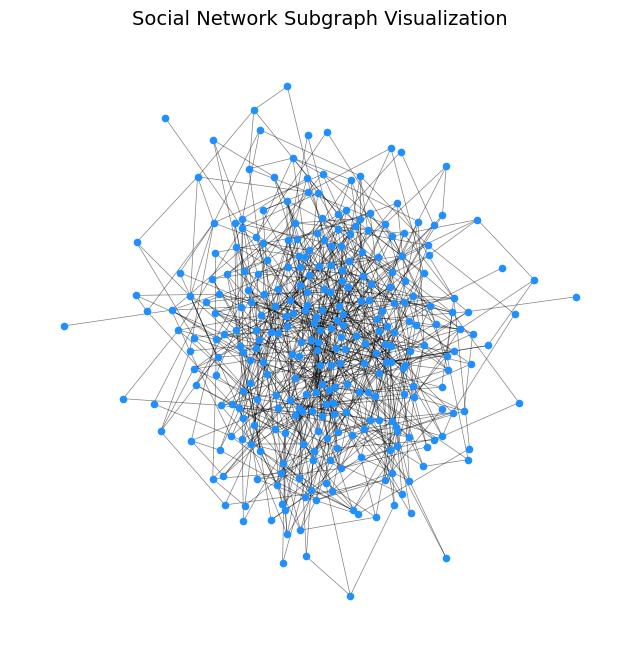

In [4]:
# Step 1: Create a random graph (Erdős-Rényi model for demo purposes)
# You can replace this with your real dataset
G = nx.erdos_renyi_graph(n=300, p=0.02)  # n=nodes, p=probability of edge creation

# Step 2: Extract the largest connected component as the "subgraph"
largest_cc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(largest_cc)

# Step 3: Draw the subgraph
plt.figure(figsize=(8,8))
pos = nx.spring_layout(subgraph, seed=42)  # Layout for node positions

nx.draw_networkx_nodes(subgraph, pos, node_size=20, node_color='dodgerblue')
nx.draw_networkx_edges(subgraph, pos, alpha=0.5, width=0.5)

plt.title("Social Network Subgraph Visualization", fontsize=14)
plt.axis("off")
plt.show()

Age vs BMI for Patients with/without PCOS

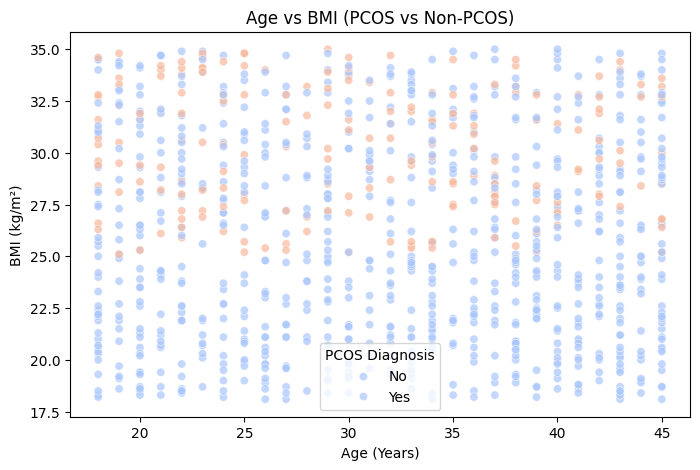

In [5]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='Age', y='BMI', hue='PCOS_Diagnosis', data=df, palette='coolwarm', alpha=0.7)
plt.title('Age vs BMI (PCOS vs Non-PCOS)')
plt.xlabel('Age (Years)')
plt.ylabel('BMI (kg/m²)')
plt.legend(title='PCOS Diagnosis', labels=['No', 'Yes'])
plt.show()

Distribution of Testosterone Level

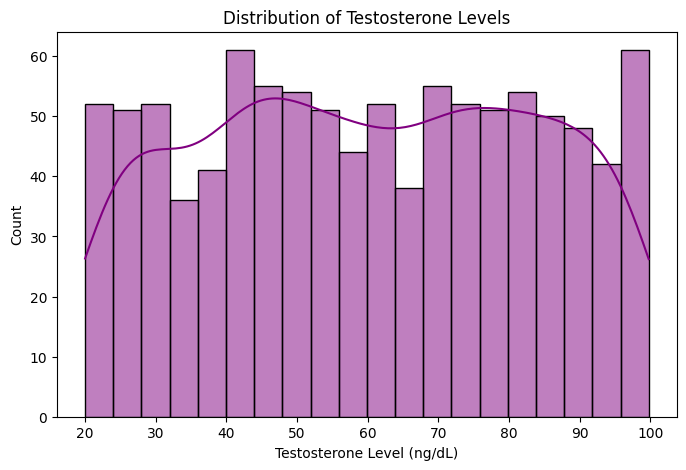

In [6]:
plt.figure(figsize=(8,5))
sns.histplot(df['Testosterone_Level(ng/dL)'], bins=20, kde=True, color='purple')
plt.title('Distribution of Testosterone Levels')
plt.xlabel('Testosterone Level (ng/dL)')
plt.ylabel('Count')
plt.show()

PCOS Cases by Menstrual Irregularity

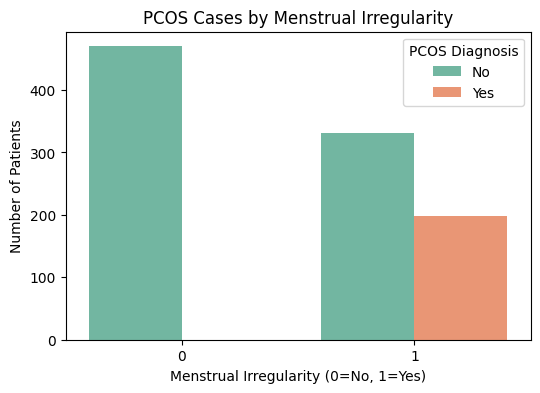

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x='Menstrual_Irregularity', hue='PCOS_Diagnosis', data=df, palette='Set2')
plt.title('PCOS Cases by Menstrual Irregularity')
plt.xlabel('Menstrual Irregularity (0=No, 1=Yes)')
plt.ylabel('Number of Patients')
plt.legend(title='PCOS Diagnosis', labels=['No', 'Yes'])
plt.show()

 Prepare Time-Series Data

In [8]:
# Generate a sequence of dates for the placeholder column
# This assumes each row corresponds to a distinct date, starting from a specific point.
# You might need to adjust the start date or frequency based on your data's context.
start_date = '2023-01-01'
num_rows = len(df)
date_range = pd.date_range(start=start_date, periods=num_rows, freq='D')

# Add the placeholder date column to the DataFrame
df['Checkup_Date'] = date_range

# Now you can re-run the code that caused the error
df['Checkup_Date'] = pd.to_datetime(df['Checkup_Date'])
df.set_index('Checkup_Date', inplace=True)

# Group by month and count abnormal cases
monthly_cases = df[df['PCOS_Diagnosis'] == 1].resample('M').size()

print(monthly_cases.head())

Checkup_Date
2023-01-31    4
2023-02-28    3
2023-03-31    7
2023-04-30    8
2023-05-31    5
Freq: ME, dtype: int64


/tmp/ipython-input-1097910767.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_cases = df[df['PCOS_Diagnosis'] == 1].resample('M').size()


Split Data into Train & Test Sets

In [9]:
train = monthly_cases[:int(len(monthly_cases)*0.8)]
test = monthly_cases[int(len(monthly_cases)*0.8):]

Build the ARIMA Model

In [10]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (p, d, q values chosen after testing)
model = ARIMA(train, order=(2, 1, 2))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   26
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 -54.684
Date:                Tue, 26 Aug 2025   AIC                            119.368
Time:                        04:40:59   BIC                            125.462
Sample:                    01-31-2023   HQIC                           121.058
                         - 02-28-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1210      0.990     -1.132      0.258      -3.062       0.820
ar.L2         -0.1210      0.525     -0.231      0.818      -1.150       0.908
ma.L1         -0.0028     30.457  -9.31e-05      1.0

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast and Compare with Test Data

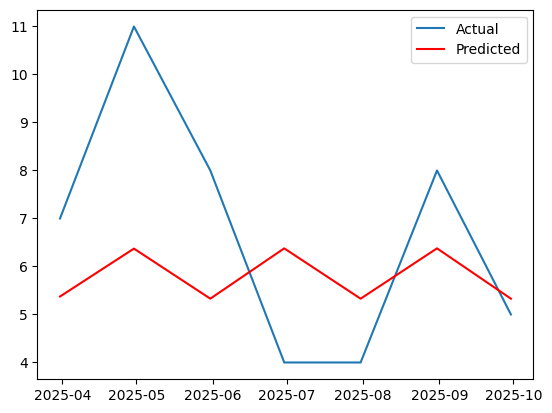

In [11]:
# Forecast
forecast = model_fit.forecast(steps=len(test))

# Compare actual vs predicted
import matplotlib.pyplot as plt

plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Predicted', color='red')
plt.legend()
plt.show()

Validate Model Performance

In [12]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test, forecast)
print("MSE:", mse)

MSE: 5.907160762455497


Confusion Matrix

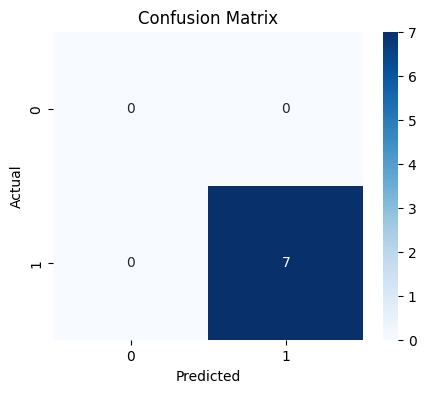

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert continuous predictions to binary using threshold
threshold = 1
y_true = (test.values >= threshold).astype(int)
y_pred = (forecast.values >= threshold).astype(int)

# Force both classes (0 and 1) to appear in matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plot confusion matrix as heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Model Evaluation matrix

In [14]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to calculate evaluation metrics
def evaluate_model(y_true, y_pred, threshold=1):
    y_true_bin = (y_true >= threshold).astype(int)
    y_pred_bin = (y_pred >= threshold).astype(int)

    return {
        'Accuracy':  accuracy_score(y_true_bin, y_pred_bin),
        'Precision': precision_score(y_true_bin, y_pred_bin, zero_division=0),
        'Recall':    recall_score(y_true_bin, y_pred_bin, zero_division=0),
        'F1 Score':  f1_score(y_true_bin, y_pred_bin, zero_division=0)
    }

# ---- TRAIN EVALUATION ----
train_forecast = model_fit.predict(start=train.index[0], end=train.index[-1])
train_metrics = evaluate_model(train.values, train_forecast.values)

# ---- TEST EVALUATION ----
test_forecast = model_fit.forecast(steps=len(test))
test_metrics = evaluate_model(test.values, test_forecast.values)

# ---- VALIDATION SPLIT ----
# Example: Use the last 20% of test as validation
val_size = int(len(test) * 0.2)
val_true = test[-val_size:]
val_pred = test_forecast[-val_size:]
val_metrics = evaluate_model(val_true.values, val_pred.values)

# Combine into a DataFrame
metrics_df = pd.DataFrame([train_metrics, test_metrics, val_metrics],
                          index=['Train', 'Test', 'Validation'])

print(metrics_df)

            Accuracy  Precision    Recall  F1 Score
Train       0.961538        1.0  0.961538  0.980392
Test        1.000000        1.0  1.000000  1.000000
Validation  1.000000        1.0  1.000000  1.000000
